# The Inverted Pendulum (or the Cart-Pole System)

In this notebook, we will go through implementing the inverted pendulum system for which we'll train a neural network to learn to control the pendulum state.

We will train a separate network to learn the system dynamics as well. 

A part of this exercise will also show you how to make animations in matplotlib!

In [1]:
import typing
import warnings

import math
import torch
import einops
import neuralode

warnings.simplefilter('ignore', RuntimeWarning)
warnings.simplefilter('ignore', UserWarning)

In [2]:
# For convenience, we define the default tensor device and dtype here
torch.set_default_device('cuda')
# In neural networks, we prefer 32-bit/16-bit floats, but for precise integration, 64-bit is preferred. We will revisit this later when we need to mix integration with neural network training
torch.set_default_dtype(torch.float64)

In [3]:
mass_cart   = torch.tensor(2.0)  # kg
mass_pole   = torch.tensor(0.1)  # kg
length_pole = torch.tensor(1.0)  # m
gravity     = torch.tensor(9.81) # m/s^2
friction_cart = torch.tensor(0.0)
friction_pole = torch.tensor(0.0)

def inverted_pendulum(state, time, force, mc, mp, l, g, mu_c, mu_p):
    theta, theta_dot, x, x_dot = state[...,0], state[...,1], state[...,2], state[...,3]
    
    dtheta = theta_dot
    dx = x_dot
    
    stheta, ctheta = theta.sin(), theta.cos()
    
    theta_dot_sq = theta_dot.square()
    total_mass = mc + mp*stheta.square()
    
    if torch.all(mu_c == 0.0) and torch.all(mu_p == 0.0):
        pole_moment_of_inertia = mp * l/2
        counter_force = (force + pole_moment_of_inertia * stheta * theta_dot_sq)
        dtheta_dot = stheta * g - ctheta * counter_force / total_mass
        dtheta_dot = dtheta_dot * 2/l / (4.0/3.0 - mp * ctheta.square() / total_mass)
        dx_dot = (counter_force - pole_moment_of_inertia * ctheta * dtheta_dot)
        dx_dot = dx_dot / total_mass
    else:
        sgn_xdot = torch.sign(x_dot)
        paren1_pre = -force - mp * l/2 * theta_dot_sq * (stheta + mu_c * ctheta * sgn_xdot) + mu_c * g * sgn_xdot
        
        dtheta_dot_common = g * stheta - (mu_p / mp) * x_dot * 2/l
        dtheta_dot = dtheta_dot_common + ctheta * paren1_pre 
        dtheta_dot = dtheta_dot * 2/l / (4.0/3.0 - mp * ctheta / total_mass * (ctheta - mu_c * sgn_xdot))
        
        Nc = total_mass * g - mp * l/2 * (dtheta_dot * stheta + theta_dot_sq * ctheta)
        
        corr_needed = (torch.sign(Nc) < 0) & (mu_c > 0.0)
        sgn_Ncxdot = torch.sign(Nc*x_dot)
        paren1_post = -force - mp * l/2 * theta_dot_sq * (stheta + mu_c * ctheta * sgn_Ncxdot) + mu_c * g * sgn_Ncxdot
            
        dtheta_dot_pre = dtheta_dot_common + ctheta * paren1_post
        dtheta_dot = torch.where(corr_needed, dtheta_dot_pre * 2/l / (4.0/3.0 - mp*ctheta/total_mass * (ctheta - mu_c * sgn_Ncxdot)), dtheta_dot)
    
        Nc = torch.where(corr_needed, (mc + mp) * g - mp * l/2 * (dtheta_dot * stheta + theta_dot_sq * ctheta), Nc)
            
        dx_dot = (force + mp * (theta_dot_sq * stheta - dtheta_dot * ctheta) - mu_c * Nc * torch.sign(Nc * x_dot))/(mc + mp)
    
    return torch.stack([
        dtheta,
        dtheta_dot,
        dx,
        dx_dot
        ], dim=-1)

In [4]:
initial_state = torch.tensor([torch.pi,0.0,0.0,0.0])

initial_time = torch.tensor(0.0)
final_time   = torch.tensor(10.0)

initial_timestep = torch.tensor(1e-2)

current_integrator = neuralode.integrators.AdaptiveRK45Integrator

atol, rtol = torch.tensor(0.0), torch.tensor(1e-4)

In [5]:
final_state, _, sha_states, sha_times, _ = current_integrator.apply(inverted_pendulum, initial_state, initial_time, final_time, initial_timestep, {'atol': atol, 'rtol': rtol}, torch.tensor(0.0), mass_cart, mass_pole, length_pole, gravity, friction_cart, friction_pole)

In [6]:
import matplotlib.pyplot as plt

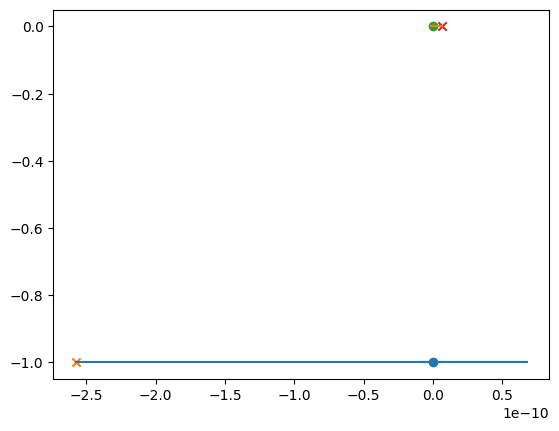

In [7]:
pendulum_x = torch.sin(sha_states[...,0]) * length_pole + sha_states[...,2]
pendulum_y = torch.cos(sha_states[...,0]) * length_pole

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(pendulum_x[0].item(), pendulum_y[0].item(), marker='o')
ax.scatter(pendulum_x[-1].item(), pendulum_y[-1].item(), marker='x')
ax.plot(pendulum_x.cpu().numpy(), pendulum_y.cpu().numpy())
ax.plot(sha_states[...,2].cpu().numpy(), torch.zeros_like(sha_states[...,2]).cpu().numpy())
ax.scatter(sha_states[...,2][0].item(), 0.0, marker='o')
ax.scatter(sha_states[...,2][-1].item(), 0.0, marker='x')

In [8]:
# we define our network as a subclass of torch.nn.Module
# This allows PyTorch to appropriately track parameters
class CartPoleNet(torch.nn.Module):
    def __init__(self):
        # First we initialise the superclass, `torch.nn.Module`
        super().__init__()
        # Then we define the actual neural network
        # Most Neural Networks operate sequentially so they can be wrapped
        # inside a torch.nn.Sequential which takes each layer
        # as an argument.
        # Since we're only learning one matrix, we have
        # one layer, the `torch.nn.Linear`.
        # `torch.nn.Linear` stores a matrix and a bias which actually makes it
        # an Affine transformation rather than a purely linear transformation
        self.internal_net = torch.nn.Sequential(
            torch.nn.Linear(5, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 1),
        )
    
    def forward(self, x, t):
        # Our network only depends on x, but since it could also depend on t, we have
        # included it for completeness
        # Additionally, PyTorch layers and modules expect a batched tensor
        # ie. a tensor where the first dimension is over different samples
        # Since we don't depend on batches, we check if the input is 1-dimensional
        # And add a batch dimension as needed for the internal module
        encoded_state = torch.stack(
            [torch.cos(x[...,0]), torch.sin(x[...,0]), x[...,1], x[...,2], x[...,3]],
        dim=-1)
        if x.dim() == 1:
            return self.internal_net(encoded_state[None])[0]
        else:
            return self.internal_net(encoded_state)
        
cart_pole_net = CartPoleNet()
# And then instantiate the weights of the network itself
def init_weights(m):
    # For each layer type, we can define how we initialise its values
    if isinstance(m, torch.nn.Linear):
        # A linear equation with a positive coefficient
        # translates to exponential growth and a negative coefficient
        # to exponential decay. In order to preserve stability we sample a matrix
        # that is biased to be negative in its entries thus ensuring
        # that our initial system is of exponential decay.
        torch.nn.init.xavier_normal_(m.weight, gain=0.25)
        if m.bias is not None:
            torch.nn.init.normal_(m.bias, std=0.01)

cart_pole_net.apply(init_weights)

def nn_controlled_pendulum(state, time, mc, mp, l, g, mu_c, mu_p, *args):
    force = cart_pole_net(state, time)[...,0]
    return inverted_pendulum(state, time, force, mc, mp, l, g, mu_c, mu_p)

In [9]:
# As the goal is balancing the pole on top of the cart, we generate several initial states where the pole
# is near vertical and moving with some random rotational velocity. This way, the neural network observes
# multiple states near the vertical state where it needs to learn to counter-balance it.

state_min = torch.tensor([-torch.pi*1e-1, -1e-3*torch.pi/(final_time - initial_time), 0.0, 0.0])
state_max = torch.tensor([ torch.pi*1e-1,  1e-3*torch.pi/(final_time - initial_time), 0.0, 0.0])
state_dataset = torch.rand(64, 4) * (state_max - state_min)[None] + state_min[None]
# # Additionally, we want to include the state where the pendulum is hanging below the cart so that the network
# # can learn how to swing the pendulum back over the cart
# state_dataset = torch.cat([state_dataset, initial_state[None]], dim=0)

def batched_integrator(x0):
    return current_integrator.apply(nn_controlled_pendulum, x0, initial_time, final_time, initial_timestep, {'atol': atol, 'rtol': rtol}, mass_cart, mass_pole, length_pole, gravity, friction_cart, friction_pole, *cart_pole_net.parameters())

# First, we'll create an `optimiser` following pytorch convention
optimiser = torch.optim.Adam(cart_pole_net.parameters(), lr=5e-2, amsgrad=True)
# # Whenever the loss plateaus, we can reduce the learning rate to improve convergence
lr_on_plateau = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, patience=5)

def pendulum_closure(minibatch):
    optimiser.zero_grad()
    
    states = minibatch['states']
    
    final_state, final_time, intermediate_states, intermediate_times, _ = batched_integrator(states)

    pole_angle = final_state[...,0]
    pole_angular_velocity = final_state[...,1]
    cart_position = final_state[...,2]
    cart_velocity = final_state[...,3]
    error = (4*pole_angle.square() + 4*cart_velocity.square() + pole_angular_velocity.square() + 1e-2*cart_position.square()).mean()
    
    pole_angle_at_each_tstep = intermediate_states[...,0]
    error = error + 1e-2*pole_angle_at_each_tstep.square().mean()
    
    if error.requires_grad:
        error.backward()
    return error

# We need to set the size of our mini-batches
batch_size = 32

# Now we need an optimisation `loop` where we will take steps to minimise the error
number_of_gd_steps = 1024

In [10]:
class PID(torch.nn.Module):
    def __init__(self, target_state, p, i, d):
        super().__init__()
        self.target_state = torch.nn.Parameter(torch.as_tensor(target_state), requires_grad=False)
        self.p = torch.nn.Parameter(torch.as_tensor(p))
        self.i = torch.nn.Parameter(torch.as_tensor(i))
        self.d = torch.nn.Parameter(torch.as_tensor(d))
        self.integral = torch.tensor(0.0)
        self.derivative = torch.tensor(0.0)
        self.prev_error = torch.tensor(0.0)
        
    def forward(self, state):
        error = state - self.target_state
        self.integral = self.integral + error.detach()
        self.derivative = error.detach() - self.prev_error
        self.prev_error = error.detach()
        pid = (self.p * error + self.i * self.integral + self.d * self.derivative)[...,0]
        
        return torch.sigmoid(pid)

pid_controller = PID(torch.tensor([0.0,0.0,0.0,0.0]), 0.1, 0.01, 0.5)

def pid_controlled_pendulum(state, time, mc, mp, l, g, mu_c, mu_p, *args):
    force = pid_controller(state)
    return inverted_pendulum(state, time, force, mc, mp, l, g, mu_c, mu_p)

In [ ]:
best_error = torch.inf
best_params = cart_pole_net.state_dict()

cart_pole_net.train()

for step in range(number_of_gd_steps):
    epoch_error = 0.0
    shuffled_indices = torch.randperm(state_dataset.shape[0])
    for batch_idx in range(0, state_dataset.shape[0], batch_size):
        batch_dict = {
            'states': state_dataset[shuffled_indices][batch_idx:batch_idx+batch_size],
        }
    
        step_error = optimiser.step(lambda: pendulum_closure(batch_dict))
        epoch_error = epoch_error + step_error.item()*batch_dict['states'].shape[0]
        print(f"[{step+1}/{number_of_gd_steps}]/[{batch_idx}/{state_dataset.shape[0]}] Batch Error: {step_error:.6f}", end='\r')
    epoch_error = epoch_error/state_dataset.shape[0]
    if epoch_error < best_error:
        best_error = epoch_error
        best_params = cart_pole_net.state_dict()
    lr_on_plateau.step(epoch_error)
    print(" "*128, end="\r")
    print(f"[{step+1}/{number_of_gd_steps} - {lr_on_plateau.get_last_lr()[0]}] Epoch Error: {epoch_error:.6f}")
    # If the step size is too small, then we can interrupt the
    # training as it will not lead to significant improvements
    if lr_on_plateau.get_last_lr()[0] < 1e-6:
        break

In [100]:
cart_pole_net.load_state_dict(best_params)
cart_pole_net.eval()

final_state, _, sha_states, sha_times, _ = current_integrator.apply(nn_controlled_pendulum, state_dataset[0], initial_time, final_time, initial_timestep, {'atol': atol, 'rtol': rtol}, mass_cart, mass_pole, length_pole, gravity, friction_cart, friction_pole)

cart_pole_net(sha_states, sha_times)

tensor([[-13.7700],
        [-12.9700],
        [-11.8809],
        [-10.3498],
        [ -8.2305],
        [ -5.2838],
        [ -2.0986],
        [ -0.0967],
        [  1.0875],
        [  1.6556],
        [  1.6240],
        [  0.6310],
        [ -1.7184],
        [ -3.1747],
        [ -3.5625],
        [ -2.3812],
        [ -0.4291],
        [  2.3816],
        [  4.6387],
        [  4.8484],
        [  2.2458],
        [ -0.7768],
        [ -0.5410],
        [  2.1576],
        [  4.8808],
        [  0.5401],
        [ -4.0670],
        [ -3.3395],
        [  0.0790],
        [  1.5951],
        [  2.7023],
        [  1.0437],
        [ -1.0624],
        [ -2.3017],
        [ -2.4306],
        [ -3.1610],
        [ -3.6386],
        [ -3.5402],
        [ -2.6176],
        [ -0.7636],
        [  1.2632],
        [  4.3177],
        [  4.0696],
        [  1.1342],
        [  0.8576],
        [  2.3163],
        [  2.3596],
        [ -1.1729],
        [ -3.6339],
        [ -1.9427],


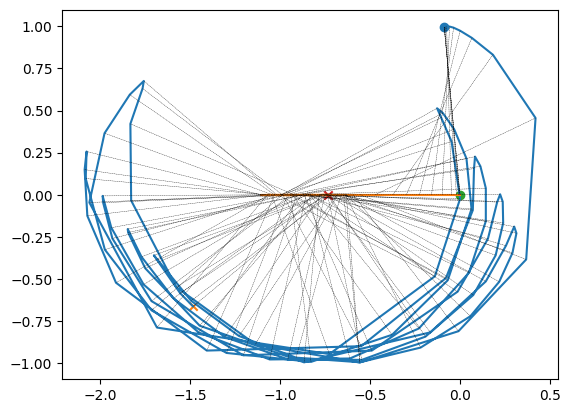

In [101]:
cart_x = sha_states[...,2]
cart_y = torch.zeros_like(cart_x)

pendulum_x = torch.sin(sha_states[...,0]) * length_pole + cart_x
pendulum_y = torch.cos(sha_states[...,0]) * length_pole

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(pendulum_x.cpu().numpy(), pendulum_y.cpu().numpy())
ax.plot(cart_x.cpu().numpy(), cart_y.cpu().numpy())

for cx, cy, wx, wy in zip(cart_x, cart_y, pendulum_x, pendulum_y):
    ax.plot([cx.item(), wx.item()], [cy.item(), wy.item()], linewidth=0.25, linestyle='--', color='k')

ax.scatter(pendulum_x[0].item(), pendulum_y[0].item(), marker='o')
ax.scatter(pendulum_x[-1].item(), pendulum_y[-1].item(), marker='x')
ax.scatter(cart_x[0].item(), cart_y[0].item(), marker='o')
ax.scatter(cart_x[-1].item(), cart_y[-1].item(), marker='x')